**Date : 02.06.2018**

**Mathieu LAMIOT, Sohyeong KIM**

# Chapter 4: Deep Learning (Part 2)- Intro to Deep Neural Networks
# Simple Linear Model and Multi-layer Perceptron (MLP)

by Behzad Bozorgtabar

## Introduction

In this section, we will learn the basic workflow of using TensorFlow with a simple linear model and multilayer perceptron model, respectively. In the previous part, we got familiar with the basic logistic classifier using (LogisticRegression or LogisticRegressionCv). You won't suffer from using the logistic classifier. But, you can obviously see the performance efficiency while using the deep neural network classifier.

In the last couple of years, deep learning has produced state-of-the-art results in many computer vision tasks. In this section, a practical overview of deep Learning's basic concepts has been provided and we are going to work with a simple linear and multi-layer perceptron (MLP) models.

At its core, deep learning is a class of neural network models. That is a model with an input layer, an output layer, and an arbitrary number of hidden layers. These layers are made up of neurons or neural units. They are called neurons because they share some similarities with the behaviour of the neurons present in the human brain. For our purposes, we can think of a neuron as a nonlinear function of the weighted sum of its inputs. Since the neuron is really the most basic part of any deep learning model it is a good place to start. 

As the starting point, we continue to work the notMNIST dataset. After loading the dataset, we define and optimize a simple mathematical model in TensorFlow. The results are then plotted and discussed. First, we import tensorflow with other needed packages:

## Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix

C:\Users\agadg\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


You can figure out your tensorflow version by running the following command:

In [2]:
tf.__version__

'1.8.0'

## Load Data

Just recap from the previous part, we need to load the the notMNIST dataset with the labels (pickle file) that we saved before. 

In [4]:
import pickle as pickle

# Data path
PICKLE_FILE = 'notMNIST.npy'
# Load the data to the RAM
SAVE_FILE = np.load(PICKLE_FILE)
#SAVE_FILE = SAVE_FILE.item();
TRAIN_DATASET = SAVE_FILE['train_dataset']
TRAIN_LABELS = SAVE_FILE['train_labels']

VALID_DATASET = SAVE_FILE['valid_dataset']
VALID_LABELS = SAVE_FILE['valid_labels']

TEST_DATASET = SAVE_FILE['test_dataset']
TEST_LABELS = SAVE_FILE['test_labels']

# Free some memory
del SAVE_FILE

The notMNIST dataset has now been loaded and consists of images and associated labels (i.e. classifications of the images). The dataset is split into 3 mutually exclusive sub-sets (200000 training images, 10000 validation and 10000 test images, respectively). You can display the images in each sub-set. They should match the labels.

In [5]:
# Display the openend files
print("Training Set ", TRAIN_DATASET.shape, TRAIN_LABELS.shape)
print("Validation Set", VALID_DATASET.shape, VALID_LABELS.shape)
print("Test Set", TEST_DATASET.shape, TEST_LABELS.shape)

Training Set  (200000, 28, 28) (200000,)
Validation Set (10000, 28, 28) (10000,)
Test Set (10000, 28, 28) (10000,)


### Helper-function for plotting images

Function used to plot 9 images in a 3x3 grid, and writing the true and predicted classes below each image.

In [6]:
IMAGE_SIZE = 28
IMAGE_SHAPE=(IMAGE_SIZE,IMAGE_SIZE)

def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(IMAGE_SHAPE), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
        
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Plot a few images to see if data is correct

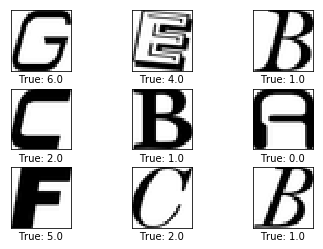

In [7]:
# Get the first images from the test-set.
images = TEST_DATASET[0:9]

# Get the true classes for those images.
cls_true = TEST_LABELS[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

### One-Hot Encoding and Image Flattened Mode

Our labels contain a list of predictions for our examples, e.g. [1, 9, ...]. In tensorflow, the label has to be converted to the encoding format as so-called One-Hot encoding. This means the labels have been converted from a single number to a vector whose length equals the number of possible classes. All elements of the vector are zero except for the $i$'th element which is one and means the class is $i$.

In addition, because we are going to use linear layers and multiplications of the neural network, you always want your data to be a (1 or) 2-dimensional matrix, where each row is the vector representing your data. Therefore, it would be more complicated and less efficient without reshaping images first. Here, we need to flatten images before passing them to our model. As an example, please print out the One-Hot encoded labels for the first 5 images in the test set.


In [8]:
def reformat(dataset, labels):
    """
        Reformat the data to the one-hot and flattened mode
    """
    n_dataset = dataset.reshape((-1, IMAGE_SIZE * IMAGE_SIZE)).astype(np.float32)

    # Convert to the one hot format
    n_labels = (np.arange(NUM_LABELS) == labels[:, None]).astype(np.float32)

    return n_dataset, n_labels


NUM_LABELS = 10

TRAIN_DATASET, TRAIN_LABELS = reformat(TRAIN_DATASET, TRAIN_LABELS)
VALID_DATASET, VALID_LABELS = reformat(VALID_DATASET, VALID_LABELS)
TEST_DATASET, TEST_LABELS = reformat(TEST_DATASET, TEST_LABELS)

# Display the files
print("Training Set ", TRAIN_DATASET.shape, TRAIN_LABELS.shape)
print("Validation Set", VALID_DATASET.shape, VALID_LABELS.shape)
print("Test Set", TEST_DATASET.shape, TEST_LABELS.shape)

Training Set  (200000, 784) (200000, 10)
Validation Set (10000, 784) (10000, 10)
Test Set (10000, 784) (10000, 10)


In [9]:
# Show labels example
TEST_LABELS[0:5, :]

array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

## TensorFlow Graph

The entire purpose of TensorFlow is to have a so-called computational graph that can be executed much more efficiently than if the same calculations were to be performed directly in Python. TensorFlow can be more efficient than NumPy because TensorFlow knows the entire computation graph that must be executed, while NumPy only knows the computation of a single mathematical operation at a time.

TensorFlow can also automatically calculate the gradients that are needed to optimize the variables of the graph to make the model perform better. This is because the graph is a combination of simple mathematical expressions so the gradient of the entire graph can be calculated using the chain rule for derivatives.


A TensorFlow graph consists of the following parts which will be detailed below:

* Placeholder variables used to change the input to the graph.
* Model variables that are going to be optimised to make the model perform better.
* The model which is essentially just a mathematical function that calculates some output given the input in the placeholder variables and the model variables.
* A cost measure that can be used to guide the optimization of the variables.
* An optimization method which updates the variables of the model.

In addition, the TensorFlow graph may also contain various debugging statements, e.g. for logging data to be displayed using TensorBoard, which is not covered here.

### Default graph

As the starting point, we create a new computational graph via the `tf.Graph` constructor. To add operations to this graph, we must register it as the default graph. The way the TensorFlow API is designed, library routines that create new operation nodes always attach these to the current default graph. We register our graph as the default by using it as a Python context manager in a `with-as` statement.


### Placeholder variables

Placeholder variables serve as the input to the graph that we may change each time we execute the graph. We call this feeding the placeholder variables and it is demonstrated further below.

First, we define the placeholder variable for the input images including train and validation set. This allows us to change the images that are input to the TensorFlow graph. This is a so-called tensor, which just means that it is a multi-dimensional vector or matrix. The data-type is set to `float32` and the shape is set to `[None, IMAGE_SIZE_FLAT]`, where `None` means that the tensor may hold an arbitrary number of images with each image being reshaped into a vector of length `IMAGE_SIZE_FLAT` which is equal to IMAGE_SIZE * IMAGE_SIZE. In addition, we create a constant tensor for the validation and test set since they are fixed and will be evaluated later.   

Next we have the placeholder variable for the true labels associated with the images that were input in the placeholder variable `TF_TRAIN_DATASET`. The shape of this placeholder variable is `[None, NUM_LABELS]` which means it may hold an arbitrary number of labels and each label is a vector of length `NUM_LABELS` which is 10 in this case.

### Variables to be optimized

Apart from the placeholder variables that were defined above and which serve as feeding input data into the model, there are also some model variables that must be changed by TensorFlow to make the model perform better on the training data.

In fact, the model variables are the network hidden layer parameters including layer's weights and biases. The first variable that must be optimized are `WEIGHTS` and defined here as a TensorFlow variable that must be initialized and whose shape is `[IMAGE_SIZE_FLAT, NUM_LABELS]` for the simple linear model, so it is a 2-dimensional tensor (or matrix) with `IMAGE_SIZE_FLAT` rows and `NUM_LABELS` columns. There are various ways to initialize the weights like initialization with zeros `tf.zeros`, `tf.truncated_normal` and `tf.random_normal`, which output random values from a normal distribution and you can specify the mean and The standard deviation (`stddev`) of the normal distribution.

The second variable that must be optimized is called `BIASES` and is defined as a 1-dimensional tensor (or vector) of length `NUM_LABELS`.

Last but not least, you should name every important operation in your code. In complex models, it is good practice to use `scopes`. The important point is that if you want to later use some operation, you have to either name it or put it into a collection.

### Model

This simple mathematical model multiplies the training images in the placeholder variable `TF_TRAIN_DATASET` with the `WEIGHTS` and then adds the ` BIASES`.

The result is a matrix of shape `[NUM_IMAGES, NUM_LABELS]` because `TF_TRAIN_DATASET` has shape `[NUM_IMAGES, IMAGE_SIZE_FLAT]` and `WEIGHTS` has shape `[IMAGE_SIZE_FLAT, NUM_LABELS]`, so the multiplication of those two matrices is a matrix with shape `[NUM_IMAGES, NUM_LABELS]` and then the `BIASES` vector is added to each row of that matrix.


However, these estimates are a bit rough and difficult to interpret because the numbers may be very small or large, so we want to normalize them so that each row of the `LOGITS` matrices sums to one (see below code), and each element is limited between zero and one. This is calculated using the so-called softmax function `tf.nn.softmax`.

### Cost-function to be optimized

To make the model better at classifying the input images, we must somehow change the variables for `WEIGHTS` and `BIASES`. To do this, we first need to know how well the model currently performs by comparing the predicted output of the model to the desired output.

The cross-entropy is a performance measure used in classification. The cross-entropy is a continuous function that is always positive and if the predicted output of the model exactly matches the desired output then the cross-entropy equals zero. The goal of optimization is, therefore, to minimise the cross-entropy, so it gets as close to zero as possible by changing the `WEIGHTS` and `BIASES` of the model.

TensorFlow has a built-in function for calculating the cross-entropy using `tf.nn.softmax_cross_entropy_with_logits`. Note that it uses the values of the `LOGITS` in train, validation and test sets because it also calculates the softmax internally. In order to use the cross-entropy to guide the optimization of the model's variables we need a single scalar value, so we simply take the average of the cross-entropy using (`tf.reduce_mean`) for all the image classifications.

### Optimization method

Now that we have a cost measure that must be minimized, we can then create an optimizer. In this case it is the basic form of Gradient Descent where the step-size is set to 0.5.

Note that optimization is not performed at this point. In fact, nothing is calculated at all, we just add the optimizer-object to the TensorFlow graph for later execution.

In [10]:
IMAGE_SIZE_FLAT=IMAGE_SIZE * IMAGE_SIZE

# Create a new graph
GRAPH = tf.Graph()

# Register the graph as the default one to add nodes
with GRAPH.as_default():
    
    # Define placeholders
    TF_TRAIN_DATASET = tf.placeholder(tf.float32, shape=(None, IMAGE_SIZE * IMAGE_SIZE))
    TF_TRAIN_LABELS = tf.placeholder(tf.float32, shape=(None, NUM_LABELS))
    TF_VALID_DATASET = tf.constant(VALID_DATASET)
    TF_TEST_DATASET = tf.constant(TEST_DATASET)
    
    with tf.name_scope("Linear_model"):
        
        """
           Initialize weights and biases
        """
        
        WEIGHTS = tf.Variable(tf.random_normal(shape=[IMAGE_SIZE_FLAT, NUM_LABELS], stddev=0.1))
        BIASES = tf.Variable(tf.zeros([NUM_LABELS]))
    
        """
           Compute the logits WX + b
        """ 
        TRAIN_LOGITS = tf.matmul(TF_TRAIN_DATASET, WEIGHTS) + BIASES
        VALID_LOGTIS = tf.matmul(TF_VALID_DATASET, WEIGHTS) + BIASES
        TEST_LOGITS = tf.matmul(TF_TEST_DATASET, WEIGHTS) + BIASES
    
        """
           Softmax function
        """   
        TRAIN_PREDICTION = tf.nn.softmax(TRAIN_LOGITS)
        VALID_PREDICTION = tf.nn.softmax(VALID_LOGTIS)
        TEST_PREDICTION = tf.nn.softmax(TEST_LOGITS)
    
        """
           Cost-function
        """
        CROSS_ENTROPY= tf.nn.softmax_cross_entropy_with_logits(logits=TRAIN_LOGITS, labels=TF_TRAIN_LABELS)
        COST= tf.reduce_mean(CROSS_ENTROPY)
        # Optimizer
        OPTIMIZER = tf.train.GradientDescentOptimizer(learning_rate=0.5).minimize(COST)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



### Helper-functions to show performance

Now, we need a performance measure to display the progress to the user. This can be done via defining a function to compute accuracy or confusion matrix to see whether the predicted class equals the true class of each image.

In [11]:
def accuracy(predictions, labels):
    """
        Divides the number of true predictions to the number of total predictions
    """
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1)) / predictions.shape[0])


def print_confusion_matrix(predictions, labels):

    # Convert the One-Hot encoded vectors to a single number by taking the index of the highest element
    labels=np.array([label.argmax() for label in labels])
    predictions = np.array([prediction.argmax() for prediction in predictions])

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=labels,
                          y_pred=predictions)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

    # Make various adjustments to the plot.
    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(NUM_LABELS)
    plt.xticks(tick_marks, range(NUM_LABELS))
    plt.yticks(tick_marks, range(NUM_LABELS))
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Ensure the plot is shown correctly with multiple plots
    plt.show()

## TensorFlow Run

### Create TensorFlow session

Once the TensorFlow graph has been created, we have to create a TensorFlow session which is used to execute the graph and train our model. For this, we enter a session environment using a `tf.Session` as a context manager. We pass our graph  object to its constructor, so that it knows which graph to manage. To then execute nodes, we have several options. The   most general way is to call Session.run() and pass a list of tensors we wish to compute. Alternatively, we may call `eval()` on  tensors and `run()` on  operations directly.

Before evaluating any other node, we must first ensure that the variables in our graph are initialized. Theoretically,  we could `run` the `Variable.initializer` operation for each variable. However, one most often just uses the
`tf.initialize_all_variables()` utility operation provided by TensorFlow, which in turn executes the `initializer` 
operation for each `Variable` in the graph. Then, we can perform a certain number of iterations of stochastic gradient  descent, fetching an example and label from the notMNIST dataset each time and feeding it to the run routine. 

One important point is that, there are 200,000 images in the training-set. It takes a long time to calculate the gradient of the model using all these images. We therefore use Stochastic Gradient Descent which only uses a small batch of images in each iteration of the optimizer.

In [12]:
BATCH_SIZE = 100
NUM_ITERATIONS = 5000

Variables initialized
Minibatch loss at step  0 :  3.0202537
Minibatch accuracy:  9.0
Validation accuracy:  39.19
Minibatch loss at step  500 :  0.8428253
Minibatch accuracy:  77.0
Validation accuracy:  79.05
Minibatch loss at step  1000 :  0.8055359
Minibatch accuracy:  79.0
Validation accuracy:  79.48
Minibatch loss at step  1500 :  0.74687165
Minibatch accuracy:  77.0
Validation accuracy:  80.27
Minibatch loss at step  2000 :  0.8710431
Minibatch accuracy:  81.0
Validation accuracy:  80.76
Minibatch loss at step  2500 :  0.75567895
Minibatch accuracy:  84.0
Validation accuracy:  80.08
Minibatch loss at step  3000 :  0.51819223
Minibatch accuracy:  83.0
Validation accuracy:  79.88
Minibatch loss at step  3500 :  0.75766826
Minibatch accuracy:  82.0
Validation accuracy:  79.85
Minibatch loss at step  4000 :  0.6859552
Minibatch accuracy:  78.0
Validation accuracy:  79.23
Minibatch loss at step  4500 :  0.8527361
Minibatch accuracy:  80.0
Validation accuracy:  79.94

 ------------ Fina

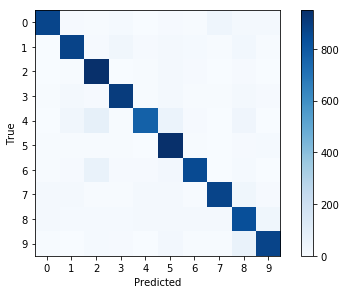

In [13]:

with tf.Session(graph=GRAPH) as session:
    """
        Start the above variable initialization
    """
    #tf.initialize_all_variables().run()
    tf.global_variables_initializer().run()
    print("Variables initialized")

    for step in range(NUM_ITERATIONS):
        """
            Generate a random base and then generate a minibatch
        """
        BASE = (step * BATCH_SIZE) % (TRAIN_LABELS.shape[0] - BATCH_SIZE)
        BATCH_DATA = TRAIN_DATASET[BASE:(BASE + BATCH_SIZE), :]
        BATCH_LABELS = TRAIN_LABELS[BASE:(BASE + BATCH_SIZE), :]
        """
            Feed the current session with batch data
        """
        FEED_DICT = {TF_TRAIN_DATASET: BATCH_DATA, TF_TRAIN_LABELS: BATCH_LABELS}
        _, l, predictions = session.run([OPTIMIZER, COST, TRAIN_PREDICTION], feed_dict=FEED_DICT)

        if(step % 500 == 0):
            print("Minibatch loss at step ", step, ": ", l)
            print("Minibatch accuracy: ", accuracy(predictions, BATCH_LABELS))
            print("Validation accuracy: ", accuracy(VALID_PREDICTION.eval(), VALID_LABELS))
            
        if (step == NUM_ITERATIONS-1): # At the last iteration print the final result
            print('\n ------------ Final Result ------------------')
            print("Test accuracy: ", accuracy(TEST_PREDICTION.eval(), TEST_LABELS))
            print_confusion_matrix(TEST_PREDICTION.eval(), TEST_LABELS)

## Multilayer Perceptron (MLP)

The next architecture we are going to work with is multilayer perceptron (MLP). An MLP can be viewed as a logistic regression classifier where the input is first transformed using some non-linear transformations of the intermediate network layers. These intermediate layers are referred to as a `hidden layers`. Here, we are going to define TF graph for the MLP model with two hidden layers and one output layer. First, let’s draw the model the MLP represents:

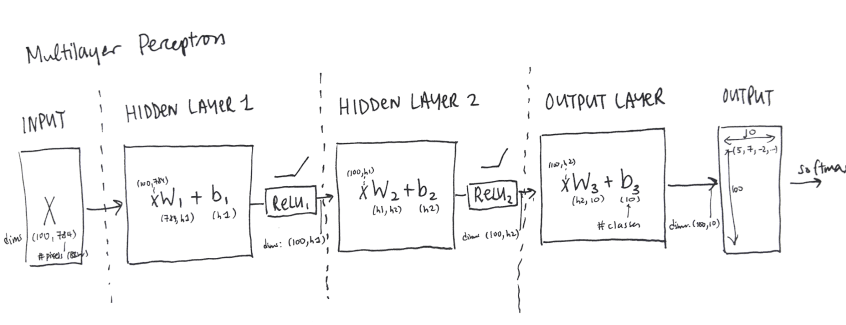

In [14]:
from IPython.core.display import Image 
Image(filename='../data/multilayer-perceptron-drawing.png')

### Problem 1

In our example, the MLP model has two hidden layers with sizes of `HIDDEN_NODES_1=1024` and `HIDDEN_NODES_2=512`, respectively. In MLP, every element of a previous layer is connected to every element of the next layer. For example, the weights in the second hidden layer has `shape=[HIDDEN_NODES_1, HIDDEN_NODES_2]`. 

Now, lets define MLP graph with two hidden layers (in the following example, we only use train and test sets):

In [15]:
#Define the number of nodes for the hidden layers
HIDDEN_NODES_1=1024
HIDDEN_NODES_2=512

MLP_GRAPH = tf.Graph()

# Register the graph as the default one to add nodes
with MLP_GRAPH.as_default():
    
    # Define placeholders
    TF_TRAIN_DATASET = tf.placeholder(tf.float32, shape=(None, IMAGE_SIZE * IMAGE_SIZE))
    TF_TRAIN_LABELS = tf.placeholder(tf.float32, shape=(None, NUM_LABELS))
    TF_TEST_DATASET = tf.constant(TEST_DATASET)
    
    with tf.name_scope("MLP_model"):
        
        """
           Initialize weights and biases
        """
        #Hidden Layers
        WEIGHTS_H1 = tf.Variable(tf.random_normal(shape=[IMAGE_SIZE_FLAT, HIDDEN_NODES_1], stddev=0.1))
        BIASES_H1 = tf.Variable(tf.zeros([HIDDEN_NODES_1]))
        
        WEIGHTS_H2 = tf.Variable(tf.random_normal(shape=[HIDDEN_NODES_1, HIDDEN_NODES_2], stddev=0.1))
        BIASES_H2 = tf.Variable(tf.zeros([HIDDEN_NODES_2]))
        
        #Output layer
        WEIGHTS_O = tf.Variable(tf.random_normal(shape=[HIDDEN_NODES_2, NUM_LABELS], stddev=0.1))
        BIASES_O = tf.Variable(tf.zeros([NUM_LABELS]))
    
        """
           Compute the logits WX + b
        """ 
        #Hidden Layer 1
        TRAIN_LAYER_H1 = tf.nn.relu( tf.matmul( TF_TRAIN_DATASET, WEIGHTS_H1) + BIASES_H1)
        TEST_LAYER_H1 = tf.nn.relu( tf.matmul( TF_TEST_DATASET, WEIGHTS_H1) + BIASES_H1)
        #Hidden Layer 2
        TRAIN_LAYER_H2 = tf.nn.relu( tf.matmul( TRAIN_LAYER_H1, WEIGHTS_H2) + BIASES_H2)
        TEST_LAYER_H2 = tf.nn.relu( tf.matmul( TEST_LAYER_H1, WEIGHTS_H2) + BIASES_H2)
        #Output Layer 
        TRAIN_LAYER_O = (tf.matmul( TRAIN_LAYER_H2, WEIGHTS_O) + BIASES_O)
        TEST_LAYER_O = (tf.matmul( TEST_LAYER_H2, WEIGHTS_O) + BIASES_O)
        """
           Softmax function
        """   
        TRAIN_PREDICTION = tf.nn.softmax(TRAIN_LAYER_O)
        TEST_PREDICTION = tf.nn.softmax(TEST_LAYER_O)
    
        """
           Cost-function
        """
        CROSS_ENTROPY= tf.nn.softmax_cross_entropy_with_logits(logits=TRAIN_LAYER_O, labels=TF_TRAIN_LABELS)
        COST= tf.reduce_mean(CROSS_ENTROPY)
        # Optimizer
        OPTIMIZER = tf.train.GradientDescentOptimizer(learning_rate=0.5).minimize(COST)

### Helper-function to perform optimization iterations

Here, we build a function for performing a number of optimization iterations so as to gradually improve the weights and biases of the MLP model. In each iteration, a new batch of data is selected from the training-set and then TensorFlow executes the optimizer using those training samples. The inputs of the function are the number of iterations `NUM_ITERATIONS` and number of used samples `NUM_SAMPLES` to train the model

In [16]:
def optimize(NUM_ITERATIONS, NUM_SAMPLES):
    
    with tf.Session(graph=MLP_GRAPH) as session:

        """
            Start the above variable initialization
        """
        # tf.initialize_all_variables().run()  
        tf.global_variables_initializer().run()

        print("Variables initialized")

        for step in range(NUM_ITERATIONS):
            """
                Select the desired samples
            """
            TRAIN_DATASET_S = TRAIN_DATASET[:NUM_SAMPLES]
            TRAIN_LABELS_S = TRAIN_LABELS[:NUM_SAMPLES]
            """
                Generate a random base and then generate a minibatch
            """
            
            indices = np.random.choice(range(TRAIN_LABELS_S.shape[0]
                                             ), BATCH_SIZE)
            BATCH_DATA = TRAIN_DATASET_S[indices, :]
            BATCH_LABELS = TRAIN_LABELS_S[indices, :]

            """
                Feed the current session with batch data
            """
            FEED_DICT = {TF_TRAIN_DATASET: BATCH_DATA, TF_TRAIN_LABELS: BATCH_LABELS}
            _, l, predictions = session.run([OPTIMIZER, COST, TRAIN_PREDICTION], feed_dict=FEED_DICT)

            if (step == NUM_ITERATIONS - 1):
                acc=accuracy(TEST_PREDICTION.eval(), TEST_LABELS)
                print("Test accuracy: ", accuracy(TEST_PREDICTION.eval(), TEST_LABELS))

    return acc

optimize(NUM_ITERATIONS=100, NUM_SAMPLES=5000)

Variables initialized
Test accuracy:  86.06


86.06

## Comparison of hand-craft feature based SVM and MLP 

Regarding the neural networks with several layers with large number of neurons, an increase in the layers/neurons will increase the capacity of the network (not accuracy). 

To generalize these large networks a significantly large number of training samples are required (atleast 10 times the number of parameters in a network) otherwise it will simply over fit even with regularization constraints. However, for the problem with quite small samples, SVM (kernel), Logistic Regression, etc. may gives better performance. 

On the other hand, when there are large number of training samples, the deep learning based model can reach much better performance. Here, we aim to train two models including SVM and MLP using varying number of training samples. For a fair comparision, we only use image raw features, but other hand-crafted features such as HOG can be used to train SVM model.


### Problem 2 
For training the SVM model, we build a similar function that we used in Part1 with some modifications. We need randomize the data and corresponding labels. In addition, the train and test labels are based on One-Hot encoding format and we need to take the index of the largest element. 

In [17]:
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC

def randomize(dataset, labels):
    #code here
    permutation_pattern = np.random.permutation(dataset.shape[0]) # Creates a permutation pattern that will be applied to the set and labels.
    shuffled_dataset=np.take(dataset,permutation_pattern,axis=0) #Apply permutation to the set
    shuffled_labels=np.take(labels,permutation_pattern,axis=0) #Apply the same permutation to the labels
    return shuffled_dataset, shuffled_labels

#Code here
def train_and_validate(NUM_SAMPLES):
    global TRAIN_DATASET, TRAIN_LABELS
    global TEST_DATASET, TEST_LABELS
    global IMAGE_SIZE
    global randomize
    
    score = np.zeros(5)
    for mc in range(0,5):
        #Randomize the training set
        shuffled_dataset, shuffled_labels = randomize(TRAIN_DATASET, np.argmax(TRAIN_LABELS,1));
        training_set = shuffled_dataset[0:NUM_SAMPLES,:];
        training_labels = shuffled_labels[0:NUM_SAMPLES];
        
        lrcv = LinearSVC();
        lrcv.fit(training_set,training_labels)
        score[mc] = lrcv.score(TEST_DATASET,np.argmax(TEST_LABELS,1))
    return score.mean()

#Example
TRAINING_SIZES = [1000, 2000]

for size in TRAINING_SIZES:
    score = train_and_validate(size)
    print("Samples:", size, "---> Score:", score)

Samples: 1000 ---> Score: 0.7927799999999999
Samples: 2000 ---> Score: 0.79406


### Problem 3

Now, we want to train and compare SVM model with the MLP model with two hidden-layers that we defined before. You should use varying number of training samples including 200, 500, 1000 ,5000, 8000 and 10000 images. At the end, we want to draw two acuracies (MLP accuracy and SVM accuracy) vs number of training samples in one SINGLE plot to have a better understanding of our models performance. With a increase in the number of training samples, the performance gap between two models will be more visible. 

Training with the size of 200....
Variables initialized
Test accuracy:  63.55
Training with the size of 500....
Variables initialized
Test accuracy:  81.37
Training with the size of 1000....
Variables initialized
Test accuracy:  81.21
Training with the size of 5000....
Variables initialized
Test accuracy:  86.39
Training with the size of 8000....
Variables initialized
Test accuracy:  85.72
Training with the size of 10000....
Variables initialized
Test accuracy:  86.17


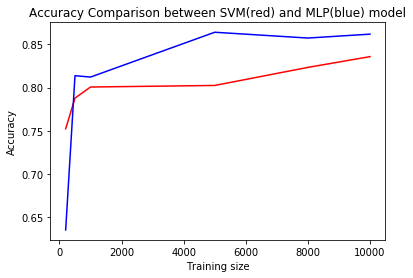

In [19]:
TRAINING_SIZES = [200, 500, 1000, 5000, 8000, 10000]
#TRAINING_SIZES = [200, 500]

#Code here
SVM_acc = np.zeros(len(TRAINING_SIZES))
MLP_acc = np.zeros(len(TRAINING_SIZES))
for sizeID in range(0,len(TRAINING_SIZES)):
    print('Training with the size of {}....'.format(TRAINING_SIZES[sizeID]))
    SVM_acc[sizeID] = train_and_validate(TRAINING_SIZES[sizeID])
    MLP_acc[sizeID] = optimize(NUM_ITERATIONS=100, NUM_SAMPLES=TRAINING_SIZES[sizeID])/100

#Plot
plt.plot(TRAINING_SIZES, SVM_acc, 'r') # plotting t, a separately 
plt.plot(TRAINING_SIZES, MLP_acc, 'b') # plotting t, b separately 
plt.xlabel('Training size')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison between SVM(red) and MLP(blue) model')
plt.show()

With a tool low training set, the MLP doesn't manage to achieve performances comparable to those of the SVM. However, with an increasing number of training samples, the MLP manages to be more accurate a quickly outperforms the SVM and reaches an accuracy above 85%.